In [1]:
import pyspark
import math
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd

In [2]:
sc = pyspark.SparkContext(appName="jojo")

In [3]:
sc

<SparkContext master=local[*] appName=jojo>

In [4]:
rdd = sc.sequenceFile("part-00000")

In [5]:
rdd.count()

36133

In [6]:
result = rdd.take(10)

In [7]:
def conta_palavras_doc(item):
    url, conteudo = item
    palavras = conteudo.strip().split()
    return [(palavra, 1) for palavra in set(palavras)]

def junta_contagens(nova_contagem, contagem_atual):
    return nova_contagem + contagem_atual

rdd_doc_freq = rdd.flatMap(conta_palavras_doc).reduceByKey(junta_contagens)

In [8]:
def conta_uma_palavra(item, palavra):
    url, conteudo = item
    palavras = conteudo.strip().split()
    #count = 0
    lista = [palavra.lower() for palavra in palavras]
    if palavra in lista:
        return [item]
    return []


Rakin = rdd.filter(lambda x:"azure" in x[1])
Yoda = rdd.filter(lambda x:"aws" in x[1])
inter = rdd.filter(lambda x:"azure" in x[1] and "aws" in x[1])

rdd_Rakin = Rakin.flatMap(conta_uma_palavra).reduceByKey(junta_contagens)
rdd_Yoda = Yoda.flatMap(conta_uma_palavra).reduceByKey(junta_contagens)
rdd_inter = inter.flatMap(conta_uma_palavra).reduceByKey(junta_contagens)

rdd_doc_rakin = Rakin.flatMap(conta_palavras_doc).reduceByKey(junta_contagens)
rdd_doc_yoda = Yoda.flatMap(conta_palavras_doc).reduceByKey(junta_contagens)
rdd_doc_inter = inter.flatMap(conta_palavras_doc).reduceByKey(junta_contagens)

In [9]:
rdd_doc_rakin.count()

18911

In [10]:
rdd_doc_yoda.count()

132874

In [11]:
rdd_doc_inter.count()

4541

In [12]:
#rdd_doc_freq.count() #Numero de documentos

In [13]:
N = rdd.count()

In [14]:
DOC_COUNT_MIN = 5
DOC_COUNT_MAX = 0.7*N

def filtra_doc_freq(item):
    contagem = item[1]
    return (contagem < DOC_COUNT_MAX) and (contagem >= DOC_COUNT_MIN)

rdd_doc_rakin_freq_filtrado = rdd_doc_rakin.filter(filtra_doc_freq)
rdd_doc_yoda_freq_filtrado = rdd_doc_yoda.filter(filtra_doc_freq)
rdd_doc_inter_freq_filtrado = rdd_doc_inter.filter(filtra_doc_freq)

In [15]:
#rdd_doc_rakin_freq_filtrado.count() #Documentos filtrado no range definido

In [16]:
def computa_idf(item):
    palavra,contagem = item
    idf = math.log10(N/contagem)
    return (palavra,idf)

def computa_freq(item):
    palavra,contagem = item
    quant = math.log10(1+contagem)
    return (palavra,quant)

rakin_rdd_idf = rdd_doc_rakin_freq_filtrado.map(computa_idf)
yoda_rdd_idf = rdd_doc_yoda_freq_filtrado.map(computa_idf)
inter_rdd_idf = rdd_doc_inter_freq_filtrado.map(computa_idf)

rakin_rdd_freq = rdd_doc_rakin_freq_filtrado.map(computa_freq)
yoda_rdd_freq = rdd_doc_yoda_freq_filtrado.map(computa_freq)
inter_rdd_freq = rdd_doc_inter_freq_filtrado.map(computa_freq)

In [17]:
def relevancia(item):
    palavra, quant = item
    freq, idf = quant
    relevancia = freq*idf
    return (palavra, relevancia)

In [18]:
result = rakin_rdd_idf.collect()

In [19]:
#sorted(result, key=lambda x: x[1])[100:]

In [20]:
rdd_rakin_join = rakin_rdd_freq.join(rakin_rdd_idf)
rdd_yoda_join = yoda_rdd_freq.join(yoda_rdd_idf)
rdd_inter_join = inter_rdd_freq.join(inter_rdd_idf)
relevancia_rakin = rdd_rakin_join.map(relevancia)
relevancia_yoda = rdd_yoda_join.map(relevancia)
relevancia_inter = rdd_inter_join.map(relevancia)

rakin_list = relevancia_rakin.takeOrdered(100, key=lambda x: -x[1])
yoda_list = relevancia_yoda.takeOrdered(100, key=lambda x: -x[1])
inter_list = relevancia_inter.takeOrdered(100, key=lambda x: -x[1])


In [21]:
result1 = relevancia_inter.collect()

In [22]:
sorted(result1, key=lambda x: x[1])[100:]

[('Evguêni', 3.0028343302598484),
 ('Alicia', 3.0028343302598484),
 ('Saturnino', 3.0028343302598484),
 ('Gomez', 3.0028343302598484),
 ('Bairros', 3.0028343302598484),
 ('Sthephanowitz', 3.0028343302598484),
 ('Naomi', 3.0028343302598484),
 ('Varoufakis', 3.0028343302598484),
 ('Ugo', 3.0028343302598484),
 ('Espaço', 3.0028343302598484),
 ('Carolina', 3.0028343302598484),
 ('Sánchez', 3.0028343302598484),
 ('Beatriz', 3.0028343302598484),
 ('D´Ávila', 3.0028343302598484),
 ('Maior*', 3.0028343302598484),
 ('Valquíria', 3.0028343302598484),
 ('Benedita', 3.0028343302598484),
 ('Ospina', 3.0028343302598484),
 ('Vermelho', 3.0028343302598484),
 ('Jalife-Rahme', 3.0028343302598484),
 ('Bessa', 3.0028343302598484),
 ('Cannavò', 3.0028343302598484),
 ('Carliana', 3.0028343302598484),
 ('gestores', 3.0028343302598484),
 ('Fagnani', 3.0028343302598484),
 ('Pavam', 3.0028343302598484),
 ('Saraiva', 3.0028343302598484),
 ('of', 3.0028343302598484),
 ('Giassi', 3.0028343302598484),
 ('Felippe*',

In [23]:
stopwords = set(STOPWORDS)
stopwords.update(["da", "meu", "em", "você", "de", "ao", "os"])

In [24]:
def concat(item):
  summary = {}
  for s, c in item:
    summary[s] = c
    return summary

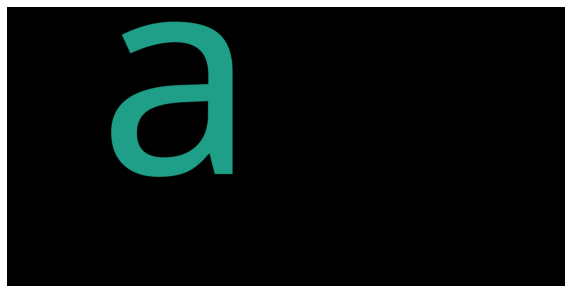

In [25]:
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate_from_frequencies(frequencies=concat(rakin_list))
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);
wordcloud.to_file("airbnb_summary_wordcloud.png")

In [26]:
rakin_data = pd.DataFrame(data = rakin_list, columns=["palavra", "relevancia"])
yoda_data = pd.DataFrame(data = yoda_list, columns=["palavra", "relevancia"])
inter_data = pd.DataFrame(data = inter_list, columns=["palavra", "relevancia"])

rakinBD = rakin_data.to_csv("rakin.csv", index=False)
yodaBD = yoda_data.to_csv("yoda.csv", index=False)
interBD = inter_data.to_csv("inter.csv", index=False)